<a href="https://colab.research.google.com/github/camayli/Trabajo-Final-Aprendiza-Autom-tico-II-/blob/main/Informe_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
TRABAJO FINAL DE APRENDIZAJE AUTOMÁTICO II
```



# **ANÁLISIS COMPARATIVO DE MODELOS DE CLASIFICACIÓN PARA LA PREDICCIÓN DE LA POTABILIDAD DEL AGUA**

*Autores*: *María Claudia Angulo Rojas*, *Patricia Contreras Parra* y *Camilo Andrés Riveros Robelto*

## **1. Importación de Paquetes**

In [ ]:
!pip install -q kagglehub[pandas-datasets]
!pip install shap

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import kagglehub
from kagglehub import KaggleDatasetAdapter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import (
    StratifiedKFold,
    RepeatedStratifiedKFold,
    StratifiedShuffleSplit,
    RandomizedSearchCV,
    cross_validate
)

from imblearn.pipeline import Pipeline

from scipy.stats import loguniform, randint

from collections import Counter

## **2. Carga del Dataset**

Se realizo la carga del conjunto de datos y una inspección inicial de su estructura.

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)
file_path = "water_potability.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "adityakadiwal/water-potability",
    file_path,
)

/tmp/ipython-input-3097011904.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'water-potability' dataset.


In [ ]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## **3. Análisis Exploratorio de Datos**

Esta sección está dedicada a realizar un análisis exploratorio de los datos. Este paso conlleva
un análisis de los datos para comprender sus patrones, características y posibles anomalías.
Para ello, se realiza una serie de técnicas relativamente simples que nos ayudarán a entender
los datos. La mayoría de los métodos que utilizaremos se basan en un examen descriptivo y
gráfico de las variables.

Comenzamos estudiando la estructura de nuestro conjunto de datos, este está compuesto por 3.276 instancias experimentales y 10 variables de estudio, de las cuales 9 corresponden a variables numéricas y una de ellas es categórica, que corresponde a la variable objetivo *Potability*.

In [ ]:
print(df.shape)

(3276, 10)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None


La distribución de la variable objetivo *Potability* muestra un desbalance donde predomina las muestras de agua no potable. Se trabajará con las clases posteriormente para evitar posibles favorecimientos a la clase predominante.

In [ ]:
print(df['Potability'].value_counts())

Potability
0    1998
1    1278
Name: count, dtype: int64


A continuación, presentamos los estadísticos descriptivos de las variables numéricas seleccionadas.

In [ ]:
print(df.describe())

                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  


En general, la mayoría de las variables presentan valores centrales representativos y una dispersión moderada, lo que indica estabilidad en las mediciones. El pH se concentra alrededor de la neutralidad, mientras que la dureza y los sulfatos muestran distribuciones aproximadamente simétricas y coherentes con parámetros habituales de agua natural.

Por otro lado, variables como los sólidos disueltos totales y la conductividad presentan una mayor variabilidad y valores extremos, lo que sugiere heterogeneidad en la composición del agua analizada. La turbidez y el carbono orgánico presentan baja dispersión, reflejando un comportamiento más uniforme en las muestras. Asimismo, se identifican valores faltantes en algunas variables, lo que evidencia la necesidad de un tratamiento previo de los datos antes de modelar nuestros datos.


**Figura 1. Variables de estudio.**

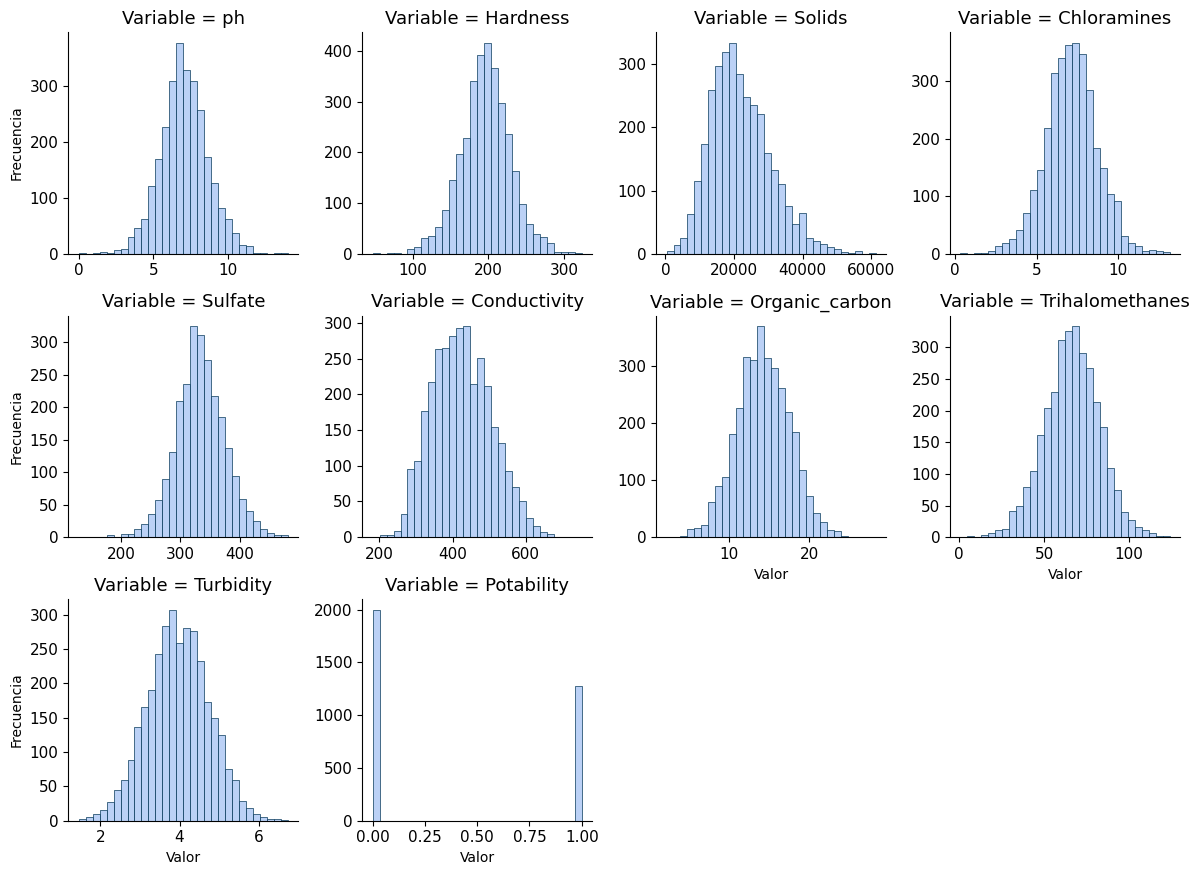

In [ ]:
df_num = df.select_dtypes(include="number")
df_long = df_num.melt(var_name="Variable",value_name="Valor")

g = sns.FacetGrid(
    df_long,
    col="Variable",
    col_wrap=4,
    sharex=False,
    sharey=False
)

g.map_dataframe(
    sns.histplot,
    x="Valor",
    bins=30,color="#A4C2F4", edgecolor="#0B3C5D")

g.set_axis_labels("Valor", "Frecuencia")

g.fig.suptitle(
    "",
    fontsize=16,
    fontweight="bold"
)

for ax in g.axes.flatten():
    ax.tick_params(labelsize=11)
    ax.set_title(ax.get_title(), fontsize=13)

plt.tight_layout()
plt.show()

## **4. Preprocesamiento de datos**

Como hemos visto en el análisis exploratorio de datos, el conjunto de datos presenta valores faltantes y una variable objetivo desbalanceada, lo que hace necesario aplicar un preprocesamiento adecuado antes del modelado.

El objetivo de esta etapa es garantizar que los modelos se entrenen sobre datos correctamente preparados, evitando sesgos y problemas como el data leakage, que ocurre cuando el modelo tiene acceso a información que no debería conocer durante el entrenamiento.

### **4.1. Separación de variables predictoras y variable objetivo**

En primer lugar, se separa la variable objetivo (*Potability*) del resto de las variables explicativas.

El resultado de la separación dará lugar a,
* ***X*** contiene las variables predictoras físico-químicas del agua.
* ***y*** corresponde a la variable objetivo binaria que indica la potabilidad del agua.

In [ ]:
X = df.drop(columns='Potability')
y = df['Potability']

### **4.2. División del conjunto de datos en entrenamiento y prueba**

Se divide el conjunto de datos en conjuntos de entrenamiento y datos de prueba para el modelado.

Esta división se realiza antes de cualquier proceso de imputación, escalado o balanceo, con el fin de evitar data leakage. Para ello se utiliza una partición del 80% para entrenamiento y 20% para prueba. Además, se aplica estratificación sobre la variable objetivo, de manera que la proporción de clases (potable y no potable) se mantenga constante en ambos subconjuntos.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### **4.3. Tratamiento de valores nulos y escalado de variables**

Como se identificó en el análisis exploratorio de datos, el conjunto presenta valores faltantes en varias variables. Dado que la mayoría de los algoritmos de aprendizaje automático no pueden manejar valores nulos de forma directa, es necesario aplicar una estrategia de imputación antes del modelado.

Previo a la imputación, se realiza el escalado de las variables, ya que el método de imputación seleccionado se basa en distancias entre observaciones.

#### **4.3.1. Escalado de variables**

Dado que las variables originales presentan diferentes escalas y unidades se aplica una estandarización mediante StandardScaler, transformando las variables para que tengan media cero y desviación estándar uno.

El escalador se ajusta únicamente sobre el conjunto de entrenamiento, y posteriormente se aplica al conjunto de prueba, evitando así el data leakage.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

#### **4.3.2. Imputación de valores nulos mediante KNN**

Para el tratamiento de los valores faltantes se emplea el método KNN Imputation, el cual estima los valores ausentes a partir de los k vecinos más cercanos en el espacio de características.

Se selecciona un valor de k = 7. Además, se utiliza la opción de ponderación por distancia, otorgando mayor peso a los vecinos más cercanos.

Al igual que en el escalado, el imputador se ajusta exclusivamente con los datos de entrenamiento y luego se aplica al conjunto de prueba.

In [ ]:
imputer = KNNImputer(
    n_neighbors=7,
    weights="distance"
)

X_train = imputer.fit_transform(X_train)
X_test  = imputer.transform(X_test)

### **4.4. Balanceo de clases**

Como se observó en el análisis exploratorio, la variable objetivo Potability presenta un desbalance de clases, con una mayor proporción de muestras correspondientes a agua no potable frente a potable. Este desbalance puede afectar negativamente el rendimiento de los modelos de clasificación, especialmente en métricas sensibles a la clase minoritaria, como el recall o el F1-score.

Con el objetivo de mitigar este problema, se aplicaron distintas técnicas de sobremuestreo exclusivamente sobre el conjunto de entrenamiento, manteniendo intacto el conjunto de prueba para asegurar una evaluación realista del desempeño de los modelos y evitar data leakage.

Se evaluaron las siguientes estrategias de balanceo:

> **SMOTE** (Synthetic Minority Over-sampling Technique), esta técnica genera nuevas observaciones sintéticas de la clase minoritaria a partir de los vecinos más cercanos.
Se probaron dos configuraciones de k = 5 y k = 7.

> **ADASYN** (Adaptive Synthetic Sampling), es una técnica variante de SMOTE que genera más muestras sintéticas en las regiones donde la clase minoritaria es más difícil de aprender. Se evaluaron las configuraciones de k = 5 y k = 9.

> **Random OverSampling**, esta técnica duplica aleatoriamente observaciones de la clase minoritaria sin generar nuevos ejemplos sintéticos.

Para cada técnica de balanceo se entrenaron y evaluaron tres modelos de clasificación ampliamente utilizados **Regresión Logística**,  **Random Forest** y **Máquinas de Vectores de Soporte (SVM)**.

Esta comparación permite analizar cómo responde cada modelo ante diferentes estrategias de balanceo. Para cada combinación de técnica de balanceo y modelo se aplica el balanceo únicamente sobre el conjunto de entrenamiento, se entrena el modelo correspondiente y se evalúa su desempeño sobre el conjunto de prueba no balanceado utilizando las siguientes métricas:

> **Accuracy**: rendimiento global del modelo.

> **Recall**: capacidad para identificar correctamente la clase potable.

> **F1-score**: equilibrio entre precisión y recall.

Los resultados obtenidos se resumen en una tabla comparativa final, la cual resume el desempeño de los tres modelos de clasificación combinados con distintas técnicas de balanceo aplicadas sobre el conjunto de entrenamiento y las métricas utilizadas.

In [ ]:
# MODELOS
models = {
    "LogisticR": LogisticRegression(max_iter=1000),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

def evaluate_models_full(X_train_bal, y_train_bal, X_test, y_test):
    metrics = {}

    for name, model in models.items():
        model.fit(X_train_bal, y_train_bal)
        y_pred = model.predict(X_test)

        metrics[f"Accuracy_{name}"] = accuracy_score(y_test, y_pred)
        metrics[f"Recall_{name}"]   = recall_score(y_test, y_pred)
        metrics[f"F1_{name}"]       = f1_score(y_test, y_pred)

    return metrics

results = []

# SMOTE k=5
smote_5 = SMOTE(k_neighbors=5, random_state=42)
X_s5, y_s5 = smote_5.fit_resample(X_train, y_train)

row = evaluate_models_full(X_s5, y_s5, X_test, y_test)
row["Balanceo"] = "SMOTE_k5"
results.append(row)

# SMOTE k=7
smote_7 = SMOTE(k_neighbors=7, random_state=42)
X_s7, y_s7 = smote_7.fit_resample(X_train, y_train)

row = evaluate_models_full(X_s7, y_s7, X_test, y_test)
row["Balanceo"] = "SMOTE_k7"
results.append(row)

# ADASYN k=5
adasyn_5 = ADASYN(n_neighbors=5, random_state=42)
X_a5, y_a5 = adasyn_5.fit_resample(X_train, y_train)

row = evaluate_models_full(X_a5, y_a5, X_test, y_test)
row["Balanceo"] = "ADASYN_k5"
results.append(row)

# ADASYN k=9
adasyn_9 = ADASYN(n_neighbors=9, random_state=42)
X_a9, y_a9 = adasyn_9.fit_resample(X_train, y_train)

row = evaluate_models_full(X_a9, y_a9, X_test, y_test)
row["Balanceo"] = "ADASYN_k9"
results.append(row)

# RANDOM OVERSAMPLING
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

row = evaluate_models_full(X_ros, y_ros, X_test, y_test)
row["Balanceo"] = "RandomOver"
results.append(row)

results_df = pd.DataFrame(results)
results_df = results_df.set_index("Balanceo")

print("TABLA FINAL DE RESULTADOS:")
results_df

TABLA FINAL DE RESULTADOS:


,Accuracy_LogisticR,Recall_LogisticR,F1_LogisticR,Accuracy_RF,Recall_RF,F1_RF,Accuracy_SVM,Recall_SVM,F1_SVM
Balanceo,,,,,,,,,
SMOTE_k5,0.539634,0.550781,0.482877,0.650915,0.480469,0.517895,0.596037,0.527344,0.504673
SMOTE_k7,0.530488,0.585938,0.493421,0.646341,0.484375,0.516667,0.625000,0.523438,0.521401
ADASYN_k5,0.481707,0.671875,0.502924,0.617378,0.464844,0.486708,0.600610,0.617188,0.546713
ADASYN_k9,0.420732,0.820312,0.525000,0.638720,0.535156,0.536204,0.574695,0.640625,0.540362
RandomOver,0.528963,0.527344,0.466321,0.661585,0.382812,0.468900,0.618902,0.472656,0.491870


La tabla de resultados muestra que ninguna técnica de balanceo domina en todas las métricas y modelos evaluados. En particular, las técnicas basadas en ADASYN logran maximizar el recall de la clase minoritaria, aunque este incremento se acompaña de una reducción en la accuracy y de una mayor variabilidad entre modelos.

Por otro lado, Random OverSampling presenta buenos valores de accuracy en determinados modelos, especialmente en Random Forest, pero su bajo recall limita su capacidad para detectar correctamente la clase minoritaria. En contraste, las configuraciones de SMOTE muestran un comportamiento más equilibrado, manteniendo valores moderados y consistentes en todas las métricas.

Al comparar las distintas configuraciones de SMOTE, no se observan diferencias sustanciales entre los valores de k evaluados, siendo las variaciones en las métricas relativamente pequeñas. En este contexto, SMOTE con k = 5 destaca por ofrecer un rendimiento estable y homogéneo en los distintos modelos, sin penalizar de forma significativa ninguna de las métricas consideradas.

Dado que el objetivo del estudio es aplicar esquemas de validación cruzada y ajuste de hiperparámetros, se prioriza una técnica de balanceo robusta y reproducible frente a mejoras puntuales en métricas individuales. Por este motivo, se selecciona SMOTE_k5 como la técnica de balanceo final para las siguientes fases del análisis.

In [ ]:
smote_5 = SMOTE(k_neighbors=5, random_state=42)
X_s5, y_s5 = smote_5.fit_resample(X_train, y_train)

print("SMOTE k=5")
print("\nNúmero total de instancias:")
print(X_s5.shape[0])
print("\nDistribución de clases:")
print(pd.Series(y_s5).value_counts())

SMOTE k=5

Número total de instancias:
3196

Distribución de clases:
Potability
0    1598
1    1598
Name: count, dtype: int64


La estrategia de balanceo SMOTE da lugar a un conjunto de datos de 3.196 instancias y una distribución igualada de clases de la variable objetivo (1.598 instancias por clase).

## **5. Evaluación del modelo**

La evaluación del desempeño de los modelos escogidos es un paso fundamental para estimar su capacidad de generalización sobre datos no vistos. Una única partición train/test puede conducir a estimaciones sesgadas del rendimiento, especialmente en conjuntos de datos de tamaño moderado y con clases desbalanceadas, como el analizado en este estudio.

Por este motivo, en lugar de depender exclusivamente de una sola división de los datos, se emplearon distintas estrategias de validación, con el objetivo de obtener una estimación más robusta, estable y fiable del desempeño de los modelos. En concreto, se utilizaron **Stratified k-fold Cross Validation**, **Repeated Stratified k-fold Cross Validation** y **Shuffle Split (estratificado)**, permitiendo analizar la sensibilidad de los modelos a distintas particiones del conjunto de datos y reducir la dependencia de una única muestra.

El uso de estas estrategias de validación responde a una reducción de la varianza de la estimación del rendimiento, ya que se minimiza el efecto del azar asociado a una única división de los datos, evaluación de la estabilidad de los modelos y aseguramiento de la generalización del modelo.

### **5.1. Stratified k-fold Cross Validation**

Stratified k-fold Cross Validation divide el conjunto de datos en k particiones (folds) estratificadas, de manera que cada fold conserva la distribución original de la variable objetivo. En cada iteración, uno de los folds se utiliza como conjunto de validación, mientras que los restantes se emplean para entrenar el modelo.

Este procedimiento se repite k veces, permitiendo que cada observación participe tanto en el entrenamiento como en la validación, y proporcionando una estimación más estable del rendimiento medio del modelo, especialmente adecuada para problemas de clasificación desbalanceada.

> **Stratified k-fold Cross Validation** (*n_splits* = 5 *shuffle* = True)

> **Logistic Regression** (*max_iter* = 1000)

> **Random Forest** (*n_estimators* = 200)

> **SVM**(*kernel* = 'rbf, *C* = 1.0, *gamma* = 'scale')

In [ ]:
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

base_steps = [
    ('imputer', KNNImputer(n_neighbors=7, weights="distance")),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=5, random_state=42))
]

scoring = {'accuracy': 'accuracy','recall': 'recall','f1': 'f1'}

In [ ]:
pipelines = {
    "LR": Pipeline(steps=base_steps + [
        ("model", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "RF": Pipeline(steps=base_steps + [
        ("model", RandomForestClassifier(
            n_estimators=200, random_state=42, n_jobs=-1
        ))
    ]),
    "SVM": Pipeline(steps=base_steps + [
        ("model", SVC(kernel="rbf", C=1.0, gamma="scale"))
    ])
}

for name, pipe in pipelines.items():
    cv_results = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    print(f"{name} | "
          f"Acc: {cv_results['test_accuracy'].mean():.3f} (± {cv_results['test_accuracy'].std():.3f}) | "
          f"Rec: {cv_results['test_recall'].mean():.3f} (± {cv_results['test_recall'].std():.3f}) | "
          f"F1:  {cv_results['test_f1'].mean():.3f} (± {cv_results['test_f1'].std():.3f})")


LR | Acc: 0.497 (± 0.012) | Rec: 0.480 (± 0.017) | F1:  0.427 (± 0.010)
RF | Acc: 0.659 (± 0.022) | Rec: 0.494 (± 0.033) | F1:  0.530 (± 0.027)
SVM | Acc: 0.641 (± 0.021) | Rec: 0.587 (± 0.039) | F1:  0.560 (± 0.027)


### **5.2. Repeated Stratified k-fold Cross Validation**

La validación cruzada estratificada repetida extiende el enfoque anterior repitiendo el proceso de k-fold varias veces con diferentes particiones aleatorias. Este método reduce aún más la varianza de la estimación del rendimiento y permite evaluar la estabilidad del modelo frente a distintas configuraciones de los folds.

Este enfoque resulta especialmente útil en procesos de comparación de modelos y ajuste de hiperparámetros, ya que proporciona métricas más robustas y menos dependientes de una partición concreta de los datos.

> **Repeated Stratified k-fold Cross Validation** (*n_splits* = 5, *n_repeats* = 5)

> Este enfoque genera un total de 25 particiones estratificadas.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=42)

base_steps = [
    ('imputer', KNNImputer(n_neighbors=7, weights="distance")),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=5, random_state=42))
]

scoring = {'accuracy': 'accuracy','recall': 'recall','f1': 'f1'}

In [ ]:
pipelines = {
    "LR": Pipeline(steps=base_steps + [
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "RF": Pipeline(steps=base_steps + [
        ('model', RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "SVM": Pipeline(steps=base_steps + [
        ('model', SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
}

for name, pipe in pipelines.items():
    cv_results = cross_validate(
        pipe,
        X, y,
        scoring=scoring,
        cv=cv,
        n_jobs=-1
    )

    print(f"{name} | "
          f"Acc: {cv_results['test_accuracy'].mean():.3f} (± {cv_results['test_accuracy'].std():.3f}) | "
          f"Rec: {cv_results['test_recall'].mean():.3f} (± {cv_results['test_recall'].std():.3f}) | "
          f"F1:  {cv_results['test_f1'].mean():.3f} (± {cv_results['test_f1'].std():.3f})")

LR | Acc: 0.507 (± 0.016) | Rec: 0.493 (± 0.029) | F1:  0.438 (± 0.019)
RF | Acc: 0.655 (± 0.017) | Rec: 0.498 (± 0.040) | F1:  0.529 (± 0.029)
SVM | Acc: 0.636 (± 0.017) | Rec: 0.591 (± 0.037) | F1:  0.558 (± 0.022)


### **5.3. Shuffle Split estratificado**

Adicionalmente, se empleó la estrategia de Shuffle Split estratificado ya que genera múltiples divisiones aleatorias del conjunto de datos, definiendo explícitamente el tamaño de los subconjuntos de entrenamiento y validación en cada iteración. Al incorporar estratificación, se asegura que la distribución de clases se mantenga en cada partición.

A diferencia del k-fold, las observaciones pueden aparecer en el conjunto de validación en varias iteraciones o no aparecer en absoluto, lo que permite evaluar el comportamiento del modelo bajo divisiones aleatorias independientes y analizar su sensibilidad a distintas configuraciones de los datos.

> **StratifiedShuffleSplit** (*n_splits* = 20)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=20,test_size=0.2,random_state=42)

base_steps = [
    ('imputer', KNNImputer(n_neighbors=7, weights="distance")),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=5, random_state=42))
]

scoring = {"accuracy": "accuracy", "recall": "recall", "f1": "f1"}

In [ ]:
pipe_lr = Pipeline(steps=base_steps + [("model", LogisticRegression(max_iter=1000, random_state=42))])
pipe_rf = Pipeline(steps=base_steps + [("model", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
pipe_svm = Pipeline(steps=base_steps + [("model", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True))])

cv_lr = cross_validate(pipe_lr, X, y, cv=sss, scoring=scoring, n_jobs=-1)
cv_rf = cross_validate(pipe_rf, X, y, cv=sss, scoring=scoring, n_jobs=-1)
cv_svm = cross_validate(pipe_svm, X, y, cv=sss, scoring=scoring, n_jobs=-1)

print("LR  | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_lr["test_accuracy"].mean(), cv_lr["test_accuracy"].std(),
    cv_lr["test_recall"].mean(), cv_lr["test_recall"].std(),
    cv_lr["test_f1"].mean(), cv_lr["test_f1"].std()
))
print("RF  | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_rf["test_accuracy"].mean(), cv_rf["test_accuracy"].std(),
    cv_rf["test_recall"].mean(), cv_rf["test_recall"].std(),
    cv_rf["test_f1"].mean(), cv_rf["test_f1"].std()
))
print("SVM | Acc: %.3f (± %.3f) | Rec: %.3f (± %.3f) | F1: %.3f (± %.3f)" % (
    cv_svm["test_accuracy"].mean(), cv_svm["test_accuracy"].std(),
    cv_svm["test_recall"].mean(), cv_svm["test_recall"].std(),
    cv_svm["test_f1"].mean(), cv_svm["test_f1"].std()
))

LR  | Acc: 0.504 (± 0.014) | Rec: 0.484 (± 0.035) | F1: 0.432 (± 0.021)
RF  | Acc: 0.651 (± 0.013) | Rec: 0.491 (± 0.033) | F1: 0.523 (± 0.024)
SVM | Acc: 0.631 (± 0.019) | Rec: 0.584 (± 0.028) | F1: 0.552 (± 0.018)


### **5.4. Resultados**

| **Estrategia de validación**      | **Modelo**              | **Accuracy (μ ± σ)** | **Recall (μ ± σ)** | **F1-score (μ ± σ)** |
| ----------------------------- | ------------------- | ---------------- | -------------- | ---------------- |
| **Stratified k-fold CV**          | Logistic Regression | 0.497 ± 0.012    | 0.480 ± 0.017  | 0.427 ± 0.010    |
|           | Random Forest       | 0.659 ± 0.022    | 0.494 ± 0.033  | 0.530 ± 0.027    |
|          | SVM                 | 0.641 ± 0.021    | 0.587 ± 0.039  | 0.560 ± 0.027    |
| **Repeated Stratified k-fold CV** | Logistic Regression | 0.507 ± 0.016    | 0.493 ± 0.029  | 0.438 ± 0.019    |
|  | Random Forest       | 0.655 ± 0.017    | 0.498 ± 0.040  | 0.529 ± 0.029    |
|  | SVM                 | 0.636 ± 0.017    | 0.591 ± 0.037  | 0.558 ± 0.022    |
| **Shuffle Split estratificado**   | Logistic Regression | 0.504 ± 0.014    | 0.484 ± 0.035  | 0.432 ± 0.021    |
|    | Random Forest       | 0.651 ± 0.013    | 0.491 ± 0.033  | 0.523 ± 0.024    |
|    | SVM                 | 0.631 ± 0.019    | 0.584 ± 0.028  | 0.552 ± 0.018    |


La Tabla presenta los resultados de la evaluación de los modelos considerados, mostrando los valores medios y las desviaciones estándar de las métricas accuracy, recall y F1-score obtenidos bajo distintas estrategias de validación. De forma general, se observa que los resultados son consistentes entre los diferentes esquemas de evaluación, con variaciones reducidas tanto en las medias como en la dispersión de las métricas, lo que sugiere que el rendimiento de los modelos es estable y no depende de una partición concreta del conjunto de datos.

Al comparar los modelos de manera global, se aprecia un patrón común en todas las estrategias de validación. La Regresión Logística presenta los valores más bajos en las métricas evaluadas, con accuracies cercanas a 0.50 y valores reducidos de recall y F1-score, lo que indica un desempeño limitado en este problema. Por el contrario, Random Forest alcanza las mayores accuracies globales, situadas en torno a 0.65, reflejando una buena capacidad de clasificación general, aunque acompañada de valores de recall moderados. En este contexto, el modelo SVM muestra un comportamiento más equilibrado, ya que, si bien su accuracy es ligeramente inferior a la de Random Forest, obtiene los valores más altos de recall y F1-score, lo que supone una mayor capacidad para identificar correctamente la clase minoritaria.

En relación con las estrategias de validación empleadas, Stratified k-fold, Repeated Stratified k-fold y Shuffle Split estratificado producen resultados muy similares en términos de medias, reforzando la robustez del análisis. No obstante, la validación cruzada estratificada repetida tiende a presentar desviaciones estándar ligeramente más estables, lo que indica una menor influencia del azar en la estimación del rendimiento. Por su parte, Shuffle Split estratificado ofrece resultados coherentes con los anteriores, aportando una evaluación complementaria basada en particiones aleatorias del conjunto de datos.


Atendiendo a los resultados mostrados en la Tabla, el modelo SVM presenta el mejor desempeño global, al obtener los valores más altos de recall y F1-score en las distintas estrategias de validación. Aunque Random Forest alcanza las mayores accuracies, su menor sensibilidad hacia la clase minoritaria limita su rendimiento en términos globales. En este contexto, SVM destaca como el modelo con un comportamiento más equilibrado entre las métricas evaluadas.

## **6. Ajuste y optimización de hiperparámetros del modelo**

Con el objetivo de mejorar el rendimiento de los modelos y analizar la sensibilidad de los resultados frente a distintas configuraciones, se llevó a cabo un proceso de ajuste de hiperparámetros mediante las técnicas de Grid Search y Random Search. Ambas estrategias se aplicaron sobre los modelos previamente definidos, manteniendo constante el esquema de preprocesamiento y validación cruzada para garantizar una comparación justa.

### **6.1. Grid Search**

El método Grid Search realiza una búsqueda exhaustiva sobre un conjunto predefinido de combinaciones de hiperparámetros. Para cada combinación, el modelo se evalúa utilizando validación cruzada estratificada, seleccionando finalmente aquella configuración que maximiza la métrica de evaluación considerada.

Este enfoque permite explorar de forma sistemática el espacio de hiperparámetros y garantiza la identificación de la mejor combinación dentro de la rejilla definida.

In [ ]:
cv_repeated = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=5,
    random_state=42
)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'f1': 'f1'
}

base_steps = [
    ('imputer', KNNImputer(n_neighbors=7, weights="distance")),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(k_neighbors=5, random_state=42))
]

In [ ]:
from sklearn.model_selection import GridSearchCV

models_grid = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "model__C": [0.01, 0.1, 1, 10]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": [100, 300],
            "model__max_depth": [5, 10, None],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__gamma": [0.01, 0.1, 1]
        }
    }
}

In [ ]:
best_models_grid = {}
results_summary_grid = []

for name, cfg in models_grid.items():
    print(f"Optimizando {name} (GridSearch)...")

    pipe = Pipeline(steps=base_steps + [
        ('model', cfg["model"])
    ])

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=cfg["params"],
        cv=cv_repeated,
        scoring="f1",
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_models_grid[name] = best_model

    cv_results = cross_validate(
        best_model,
        X, y,
        cv=cv_repeated,
        scoring=scoring,
        n_jobs=-1
    )

    results_summary_grid.append({
        "Modelo": name,
        "F1_CV": grid_search.best_score_,
        "Accuracy": f"{cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}",
        "Recall": f"{cv_results['test_recall'].mean():.3f} ± {cv_results['test_recall'].std():.3f}",
        "F1": f"{cv_results['test_f1'].mean():.3f} ± {cv_results['test_f1'].std():.3f}",
        "Mejores_Params": grid_search.best_params_
    })

    print(f"{name} terminado | Mejor F1 CV: {grid_search.best_score_:.3f}")

Optimizando Logistic Regression (GridSearch)...
Fitting 25 folds for each of 4 candidates, totalling 100 fits
Logistic Regression terminado | Mejor F1 CV: 0.439
Optimizando Random Forest (GridSearch)...
Fitting 25 folds for each of 12 candidates, totalling 300 fits
Random Forest terminado | Mejor F1 CV: 0.543
Optimizando SVM (GridSearch)...
Fitting 25 folds for each of 9 candidates, totalling 225 fits
SVM terminado | Mejor F1 CV: 0.559


In [ ]:
results_grid_df = (
    pd.DataFrame(results_summary_grid)
      .sort_values("F1_CV", ascending=False)
)

print(display(results_grid_df))

,Modelo,F1_CV,Accuracy,Recall,F1,Mejores_Params
2,SVM,0.559263,0.636 ± 0.017,0.592 ± 0.035,0.559 ± 0.020,"{'model__C': 1, 'model__gamma': 0.1}"
1,Random Forest,0.542717,0.641 ± 0.021,0.547 ± 0.037,0.543 ± 0.025,"{'model__max_depth': 10, 'model__max_features'..."
0,Logistic Regression,0.438593,0.507 ± 0.017,0.494 ± 0.028,0.439 ± 0.019,{'model__C': 0.01}


None


### **6.2. Random Search**

De forma complementaria, se empleó Random Search, que selecciona de manera aleatoria un número fijo de combinaciones de hiperparámetros a partir de distribuciones previamente definidas. A diferencia de Grid Search, este método no evalúa todas las combinaciones posibles, sino una muestra representativa del espacio de búsqueda.

En este estudio, Random Search se utilizó para analizar configuraciones más amplias de hiperparámetros, permitiendo identificar combinaciones competitivas sin incurrir en un elevado coste de cómputo.

In [ ]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "model__C": loguniform(1e-3, 1e2),
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
        "params": {
            "model__n_estimators": randint(100, 400),
            "model__max_depth": randint(3, 20),
            "model__min_samples_split": randint(2, 15),
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "model__kernel": ["rbf"],
            "model__C": loguniform(1e-2, 1e2),
            "model__gamma": loguniform(1e-3, 1)
        }
    }
}

In [ ]:
best_models = {}
results_summary = []

for name, cfg in models.items():
    print(f"Optimizando {name}...")

    pipe = Pipeline(steps=base_steps + [
        ('model', cfg["model"])
    ])

    rnd_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=cfg["params"],
        n_iter=30,
        cv=cv_repeated,
        scoring="f1",
        random_state=42,
        n_jobs=-1,
        verbose=2
    )

    rnd_search.fit(X, y)

    best_model = rnd_search.best_estimator_
    best_models[name] = best_model

    cv_results = cross_validate(
        best_model,
        X, y,
        cv=cv_repeated,
        scoring=scoring,
        n_jobs=-1
    )

    results_summary.append({
        "Modelo": name,
        "F1_CV": rnd_search.best_score_,
        "Accuracy": f"{cv_results['test_accuracy'].mean():.3f} ± {cv_results['test_accuracy'].std():.3f}",
        "Recall": f"{cv_results['test_recall'].mean():.3f} ± {cv_results['test_recall'].std():.3f}",
        "F1": f"{cv_results['test_f1'].mean():.3f} ± {cv_results['test_f1'].std():.3f}",
        "Mejores_Params": rnd_search.best_params_
    })

    print(f"{name} terminado | Mejor F1 CV: {rnd_search.best_score_:.3f}")

Optimizando Logistic Regression...
Fitting 25 folds for each of 30 candidates, totalling 750 fits
Logistic Regression terminado | Mejor F1 CV: 0.439
Optimizando Random Forest...
Fitting 25 folds for each of 30 candidates, totalling 750 fits
Random Forest terminado | Mejor F1 CV: 0.550
Optimizando SVM...
Fitting 25 folds for each of 30 candidates, totalling 750 fits
SVM terminado | Mejor F1 CV: 0.560


In [ ]:
results_df = pd.DataFrame(results_summary).sort_values("F1_CV", ascending=False)
print(display(results_df))

,Modelo,F1_CV,Accuracy,Recall,F1,Mejores_Params
2,SVM,0.559777,0.634 ± 0.017,0.597 ± 0.037,0.560 ± 0.021,"{'model__C': 8.471801418819979, 'model__gamma'..."
1,Random Forest,0.549671,0.642 ± 0.017,0.561 ± 0.039,0.550 ± 0.023,"{'model__max_depth': 10, 'model__max_features'..."
0,Logistic Regression,0.438608,0.507 ± 0.017,0.494 ± 0.029,0.439 ± 0.020,"{'model__C': 0.004982752357076452, 'model__pen..."


None


### **6.3. Resultados**

| **Método de búsqueda** | **Modelo**          | **F1_CV** | **Accuracy (μ ± σ)** | **Recall (μ ± σ)** | **F1-score (μ ± σ)** |
| ---------------------- | ------------------- | --------- | -------------------- | ------------------ | -------------------- |
| **Grid Search**        | Logistic Regression | 0.4385    | 0.507 ± 0.017        | 0.494 ± 0.028      | 0.439 ± 0.019        |
|                        | Random Forest       | 0.5427    | 0.641 ± 0.021        | 0.547 ± 0.037      | 0.543 ± 0.025        |
|                        | SVM                 | 0.5592    | 0.636 ± 0.017        | 0.592 ± 0.035      | 0.559 ± 0.020        |
| **Random Search**      | Logistic Regression | 0.4386    | 0.507 ± 0.017        | 0.494 ± 0.029      | 0.439 ± 0.020        |
|                        | Random Forest       | 0.5496    | 0.642 ± 0.017        | 0.561 ± 0.039      | 0.550 ± 0.023        |
|                        | SVM                 | 0.5597    | 0.634 ± 0.017        | 0.597 ± 0.037      | 0.560 ± 0.021        |


| **Método de búsqueda** | **Modelo**          | **Mejores hiperparámetros**                                                                                          |
| ---------------------- | ------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Grid Search**        | Logistic Regression | `model__C = 0.01`                                                                                                    |
|                        | Random Forest       | `model__n_estimators = 300`, `model__max_depth = 10`, `model__max_features = 'sqrt'`                                 |
|                        | SVM                 | `model__C = 1`, `model__gamma = 0.1`                                                                                 |
| **Random Search**      | Logistic Regression | `model__C = 0.004982752357076452`, `model__penalty = 'l2'`, `model__solver = 'lbfgs'`                                |
|                        | Random Forest       | `model__n_estimators = 153`, `model__max_depth = 10`, `model__max_features = 'log2'` |
|                        |                     |                                                                `model__min_samples_split = 3`  |
|                        | SVM                 | `model__C = 8.471801418819979`, `model__gamma = 0.06251373574521749`, `model__kernel = 'rbf'`                        |


Las tablas de resultados permiten comparar de forma directa el impacto del método de búsqueda de hiperparámetros en el rendimiento de cada modelo. En el caso de Logistic Regression, ambos métodos producen resultados prácticamente idénticos, tanto en F1_CV como en las métricas de evaluación final, lo que indica que el rendimiento del modelo es poco sensible al método de optimización empleado. Este comportamiento es coherente con el reducido número de hiperparámetros relevantes en este clasificador.

Para Random Forest, se observan diferencias más apreciables entre ambos enfoques. Random Search obtiene valores superiores de F1_CV y F1-score respecto a Grid Search, acompañados de una ligera mejora en recall, mientras que la accuracy se mantiene prácticamente constante. Esto sugiere que la exploración aleatoria permite identificar combinaciones de hiperparámetros más favorables en un espacio de búsqueda amplio y con múltiples interacciones, como es el caso de Random Forest.

En el caso de SVM, ambos métodos alcanzan resultados muy similares, aunque Random Search presenta valores marginalmente superiores en F1_CV, recall y F1-score. Estas diferencias, aunque pequeñas, indican que la búsqueda aleatoria logra ajustar con mayor precisión los hiperparámetros continuos del modelo, especialmente los relacionados con la regularización y la función de kernel.

En conjunto, la comparación muestra que Random Search tiende a ofrecer un rendimiento igual o ligeramente superior al de Grid Search. No obstante, las diferencias observadas son moderadas y la jerarquía de rendimiento entre los modelos se mantiene inalterada, lo que refuerza la estabilidad de los resultados obtenidos.

## **7. Ensembles**

Con el objetivo de analizar posibles mejoras en el rendimiento predictivo y en la estabilidad de los modelos, se exploró el uso de métodos ensemble, que combinan múltiples clasificadores con el fin de obtener predicciones más robustas y menos sensibles a variaciones en los datos de entrenamiento. La motivación principal de estos enfoques radica en que la combinación de modelos con comportamientos complementarios puede contribuir a reducir la varianza y, en determinados casos, mejorar la capacidad de generalización.

En este trabajo se evaluaron distintos enfoques ensemble que representan estrategias de combinación diferentes. Por un lado, se consideraron métodos basados en la agregación de estimadores ya entrenados, como el **Voting Classifier**, que permite integrar las predicciones de varios modelos heterogéneos. Por otro lado, se analizó un método de boosting, concretamente **Gradient Boosting**, que construye un único modelo compuesto por múltiples árboles entrenados de forma secuencial para corregir los errores de iteraciones anteriores.

### **7.1. VotingClassifier**

El VotingClassifier es un método ensemble que combina las predicciones de varios clasificadores previamente entrenados para obtener una decisión final más estable. En lugar de depender de un único modelo, este enfoque aprovecha la diversidad de distintos algoritmos con el fin de reducir el impacto de errores individuales.

En este trabajo se emplearon dos variantes del VotingClassifier: hard voting, donde la clase final se determina por mayoría simple, y soft voting, en la que se promedian las probabilidades estimadas por cada modelo.

In [ ]:
base_steps = [
    ("imputer", KNNImputer(n_neighbors=7, weights="distance")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(k_neighbors=5, random_state=42))
]

cv_repeated = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=5,
    random_state=42
)

pipe_lr = ImbPipeline(steps=base_steps + [
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rf = ImbPipeline(steps=base_steps + [
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

pipe_svm = ImbPipeline(steps=base_steps + [
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True
    ))
])

In [ ]:
voting_hard = VotingClassifier(
    estimators=[("lr", pipe_lr),("rf", pipe_rf),("svm", pipe_svm)],
    voting="hard")

voting_soft = VotingClassifier(
    estimators=
     [("lr", pipe_lr),
      ("rf", pipe_rf),
       ("svm", pipe_svm)], voting="soft")
scoring = {"accuracy": "accuracy","recall": "recall","f1": "f1"}

cv_vhard = cross_validate(voting_hard,X, y,cv=cv_repeated,scoring=scoring,
                          n_jobs=-1)

cv_vsoft = cross_validate(
    voting_soft,
    X, y,
    cv=cv_repeated,
    scoring=scoring,
    n_jobs=-1
)
print("Voting HARD")
print("Accuracy: %.3f (± %.3f)" % (cv_vhard["test_accuracy"].mean(), cv_vhard["test_accuracy"].std()))
print("Recall:   %.3f (± %.3f)" % (cv_vhard["test_recall"].mean(), cv_vhard["test_recall"].std()))
print("F1:       %.3f (± %.3f)" % (cv_vhard["test_f1"].mean(), cv_vhard["test_f1"].std()))

print("\nVoting SOFT")
print("Accuracy: %.3f (± %.3f)" % (cv_vsoft["test_accuracy"].mean(), cv_vsoft["test_accuracy"].std()))
print("Recall:   %.3f (± %.3f)" % (cv_vsoft["test_recall"].mean(), cv_vsoft["test_recall"].std()))
print("F1:       %.3f (± %.3f)" % (cv_vsoft["test_f1"].mean(), cv_vsoft["test_f1"].std()))

Voting HARD
Accuracy: 0.643 (± 0.017)
Recall:   0.538 (± 0.029)
F1:       0.540 (± 0.020)

Voting SOFT
Accuracy: 0.654 (± 0.019)
Recall:   0.556 (± 0.030)
F1:       0.556 (± 0.023)


### **7.2. Gradient Boosting**

Gradient Boosting es un método ensemble basado en boosting, en el que un conjunto de modelos débiles, generalmente árboles de decisión de poca profundidad, se entrena de forma secuencial. Cada nuevo modelo se construye para corregir los errores cometidos por los modelos anteriores, dando lugar a un clasificador final con mayor capacidad predictiva.

A diferencia de enfoques basados en la combinación directa de modelos ya entrenados, como el VotingClassifier, Gradient Boosting construye un único modelo de manera iterativa, optimizando una función de pérdida mediante técnicas de descenso por gradiente. Este enfoque permite capturar relaciones no lineales complejas entre las variables y suele ofrecer un buen rendimiento en problemas de clasificación.

In [ ]:
cv_repeated = RepeatedStratifiedKFold(
    n_splits=5,
    n_repeats=5,
    random_state=42
)

pipe_gb_balanced = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=7, weights="distance")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(k_neighbors=5, random_state=42)),
    ("model", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

cv_results_gb_bal = cross_validate(
    pipe_gb_balanced,
    X, y,
    cv=cv_repeated,
    scoring=scoring,
    n_jobs=-1
)

print("Gradient Boosting + SMOTE (Repeated Stratified CV 5×5)")
print("Accuracy: %.3f (± %.3f)" % (
    cv_results_gb_bal['test_accuracy'].mean(),
    cv_results_gb_bal['test_accuracy'].std()
))
print("Recall:   %.3f (± %.3f)" % (
    cv_results_gb_bal['test_recall'].mean(),
    cv_results_gb_bal['test_recall'].std()
))
print("F1:       %.3f (± %.3f)" % (
    cv_results_gb_bal['test_f1'].mean(),
    cv_results_gb_bal['test_f1'].std()
))

Gradient Boosting + SMOTE (Repeated Stratified CV 5×5)
Accuracy: 0.611 (± 0.014)
Recall:   0.553 (± 0.029)
F1:       0.526 (± 0.018)


### **7.3. Resultados**

La Tabla resume el rendimiento medio y la desviación estándar de los métodos ensemble evaluados mediante validación cruzada estratificada repetida.

| **Modelo / Método**              | **Accuracy (μ ± σ)** | **Recall (μ ± σ)** | **F1-score (μ ± σ)** |
|---------------------------------|----------------------|--------------------|----------------------|
| Voting HARD                     | 0.643 ± 0.017        | 0.538 ± 0.029      | 0.540 ± 0.020        |
| Voting SOFT                     | 0.653 ± 0.019        | 0.557 ± 0.030      | 0.556 ± 0.023        |
| Gradient Boosting + SMOTE       | 0.611 ± 0.014        | 0.553 ± 0.029      | 0.526 ± 0.018        |


El Voting SOFT presenta el mejor rendimiento global entre los métodos ensemble, especialmente en términos de F1-score, mientras que Gradient Boosting muestra un comportamiento competitivo en recall, aunque con un menor equilibrio global.

## **8. Comparación técnicas y modelos**

La Tabla recoge de forma resumida los resultados obtenidos en las distintas fases del estudio, incluyendo las estrategias de balanceo, los esquemas de validación, el ajuste de hiperparámetros y los métodos ensemble evaluados. Esta visión global permite comparar de manera directa el rendimiento de los modelos y facilita la selección del clasificador final.

| **Fase del análisis** | **Estrategia / Método** | **Modelo** | **Accuracy (μ ± σ)** | **Recall (μ ± σ)** | **F1-score (μ ± σ)** |
|----------------------|------------------------|------------|----------------------|--------------------|----------------------|
| Balanceo (SMOTE k=5) | Hold-out               | Logistic Regression | 0.540 | 0.551 | 0.483 |
|                      |                        | Random Forest       | 0.651 | 0.480 | 0.518 |
|                      |                        | SVM                 | 0.596 | 0.527 | 0.505 |
| Stratified k-fold CV | 5 folds                | Logistic Regression | 0.497 ± 0.012 | 0.480 ± 0.017 | 0.427 ± 0.010 |
|                      |                        | Random Forest       | 0.659 ± 0.022 | 0.494 ± 0.033 | 0.530 ± 0.027 |
|                      |                        | SVM                 | 0.641 ± 0.021 | 0.587 ± 0.039 | 0.560 ± 0.027 |
| Repeated Stratified k-fold CV | 5×5          | Logistic Regression | 0.507 ± 0.016 | 0.493 ± 0.029 | 0.438 ± 0.019 |
|                      |                        | Random Forest       | 0.655 ± 0.017 | 0.498 ± 0.040 | 0.529 ± 0.029 |
|                      |                        | SVM                 | 0.636 ± 0.017 | 0.591 ± 0.037 | 0.558 ± 0.022 |
| Stratified Shuffle Split | 20 splits (80/20) | Logistic Regression | 0.504 ± 0.014 | 0.484 ± 0.035 | 0.432 ± 0.021 |
|                      |                        | Random Forest       | 0.651 ± 0.013 | 0.491 ± 0.033 | 0.523 ± 0.024 |
|                      |                        | SVM                 | 0.631 ± 0.019 | 0.584 ± 0.028 | 0.552 ± 0.018 |
| Ajuste hiperparámetros | Grid Search          | Random Forest       | 0.641 ± 0.021 | 0.547 ± 0.037 | 0.543 ± 0.025 |
|                      |                        | SVM                 | 0.636 ± 0.017 | 0.592 ± 0.035 | 0.559 ± 0.020 |
|                      | Random Search         | Random Forest       | 0.642 ± 0.017 | 0.561 ± 0.039 | 0.550 ± 0.023 |
|                      |                        | **SVM**     | 0.634 ± 0.017 | 0.597 ± 0.037 | **0.560 ± 0.021** |
| Ensembles            | Voting HARD           | Ensemble             | 0.643 ± 0.017 | 0.538 ± 0.029 | 0.540 ± 0.020 |
|                      | Voting SOFT           | Ensemble             | 0.653 ± 0.019 | 0.557 ± 0.030 | 0.556 ± 0.023 |
|                      | Gradient Boosting + SMOTE | Ensemble        | 0.611 ± 0.014 | 0.553 ± 0.029 | 0.526 ± 0.018 |


El análisis de los resultados recogidos en la tabla anterior pone de manifiesto una mejora progresiva del rendimiento de los modelos a medida que se incorporaron técnicas más avanzadas de preprocesamiento, validación y ajuste. En una primera fase, la aplicación de técnicas de balanceo como SMOTE permitió mejorar la capacidad de los modelos para detectar la clase minoritaria, evidenciando la importancia de abordar el desbalanceo presente en los datos.

Posteriormente, la utilización de esquemas de validación cruzada estratificada, tanto en su versión estándar como repetida, proporcionó estimaciones más estables del rendimiento y permitió comparar los modelos de forma más fiable. En este contexto, los modelos basados en SVM y Random Forest mostraron un comportamiento consistente, superando de forma sistemática a la Regresión Logística.

La fase de ajuste de hiperparámetros, mediante Grid Search y Random Search, supuso una mejora adicional del rendimiento, especialmente en el caso de SVM, que alcanzó los mejores valores de F1-score y recall. Estos resultados indican que el modelo es capaz de discriminar de forma más efectiva entre las clases, aspecto clave en el problema considerado.

Con el fin de explorar posibles mejoras adicionales, se evaluaron distintos métodos ensemble, incluyendo enfoques basados en VotingClassifier y Gradient Boosting. Aunque estos métodos mostraron resultados competitivos y aportaron estabilidad en algunas métricas, no superaron al mejor modelo individual ajustado, especialmente en términos de F1-score y capacidad de discriminación de la clase minoritaria.

## **9. Modelo final seleccionado**

En base a los resultados observados en el punto anterior, se selecciona el SVM ajustado mediante Random Search como modelo final, al ofrecer el mejor equilibrio entre rendimiento predictivo, capacidad de discriminación y complejidad del modelo. La decisión de no adoptar un enfoque ensemble se justifica por la ausencia de mejoras significativas y por la mayor complejidad computacional asociada a dichos métodos.

## **10. Explicabilidad del modelo**

Una vez seleccionado el modelo final tras la comparación de los distintos enfoques evaluados, se llevó a cabo un análisis de explicabilidad con el objetivo de comprender qué variables influyen de forma más significativa en las predicciones y cómo contribuyen al proceso de decisión del sistema.

Dado que el modelo final corresponde a un SVM, cuya interpretación directa resulta limitada, se emplearon técnicas de explicabilidad adaptadas a las características del modelo y al tipo de análisis requerido. En particular, se combinó una técnica agnóstica al modelo aplicada directamente sobre el clasificador seleccionado con un análisis complementario basado en un modelo auxiliar más interpretable.

### **10.1 Importancia de variables mediante Permutation Importance (modelo final SVM)**

Como técnica principal de explicabilidad se utilizó Permutation Importance, aplicada directamente sobre el modelo final SVM entrenado. Este método evalúa la importancia de cada variable midiendo la disminución del rendimiento del modelo cuando los valores de dicha variable se permutan aleatoriamente, manteniendo el resto de características sin modificar.

Al tratarse de una técnica independiente de la estructura interna del modelo, Permutation Importance resulta especialmente adecuada para modelos como SVM, permitiendo identificar las variables con mayor impacto en el rendimiento sin necesidad de acceder a sus mecanismos internos. El análisis se realizó sobre el conjunto de test y empleando el F1-score como métrica de referencia, en coherencia con el objetivo del problema.

La Figura siguiente muestra las variables más relevantes según esta técnica, proporcionando una visión global de los factores que influyen en las predicciones del modelo final.

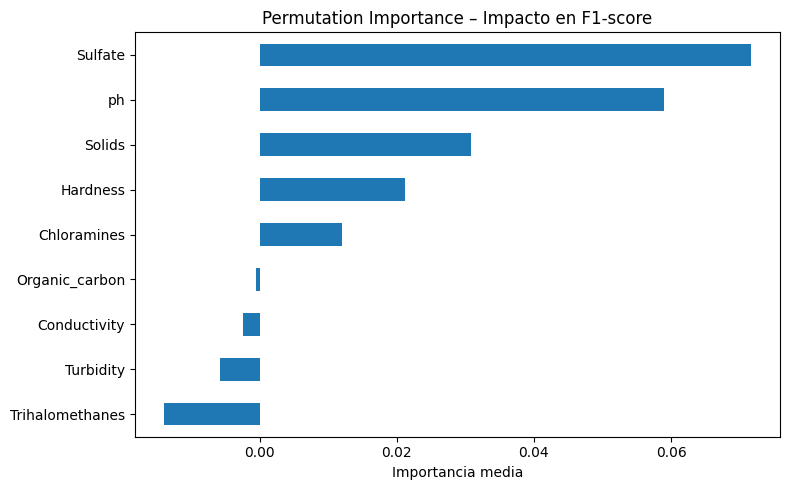

In [ ]:
final_svm_model = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=7, weights="distance")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(k_neighbors=5, random_state=42)),
    ("model", SVC(
        kernel="rbf",
        C=8.471801418819979,
        gamma=0.06251373574521749,
        probability=True,
        random_state=42
    ))
])

final_svm_model.fit(X_train, y_train)

perm = permutation_importance(
    final_svm_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="f1"
)

importances = pd.Series(
    perm.importances_mean,
    index=X.columns
).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
importances.tail(10).plot(kind="barh")
plt.title("Permutation Importance – Impacto en F1-score")
plt.xlabel("Importancia media")
plt.tight_layout()
plt.show()

### **10.2 Análisis explicativo complementario mediante SHAP (modelo auxiliar Random Forest)**

Con el fin de complementar el análisis anterior y obtener una interpretación más detallada del impacto de las variables, se empleó de forma adicional la técnica SHAP sobre un modelo auxiliar Random Forest, entrenado previamente durante la fase de experimentación.

Este análisis no pretende explicar directamente el comportamiento del modelo final, sino aportar una visión interpretativa complementaria del problema, aprovechando la estructura basada en árboles del Random Forest, que permite una aplicación eficiente de SHAP. A través de los gráficos resumen y de dependencia, se analizó tanto la importancia global de las variables como la relación entre sus valores y su contribución a la predicción.

Los resultados obtenidos mediante SHAP muestran patrones coherentes con los identificados por Permutation Importance, reforzando la robustez de las conclusiones y aportando una interpretación más intuitiva del comportamiento del sistema.

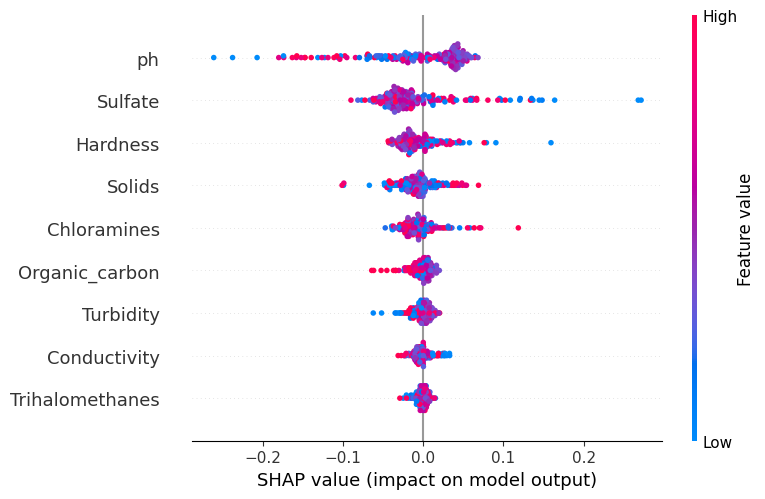

In [ ]:
best_rf = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=7, weights="distance")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(k_neighbors=5, random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=153,
        max_depth=10,
        max_features="log2",
        min_samples_split=3,
        random_state=42,
        n_jobs=-1
    ))
])

best_rf.fit(X_train, y_train)
rf_internal = best_rf.named_steps["model"]

X_test_imp = pd.DataFrame(
    best_rf.named_steps["imputer"].transform(X_test),
    columns=X.columns
)

explainer = shap.TreeExplainer(rf_internal)
shap_values = explainer.shap_values(X_test_imp.iloc[:200])

arr = np.array(shap_values)

if isinstance(shap_values, list):
    values_to_plot = shap_values[1]
elif arr.ndim == 3:
    values_to_plot = arr[:, :, 1]
else:
    values_to_plot = arr

shap.summary_plot(
    values_to_plot,
    X_test_imp.iloc[:200],
    show=True
)

Se analizó mediante un gráfico de dependencia SHAP la variable con mayor impacto medio, seleccionada automáticamente a partir de los valores SHAP.


Dependence Plot para la variable: ph


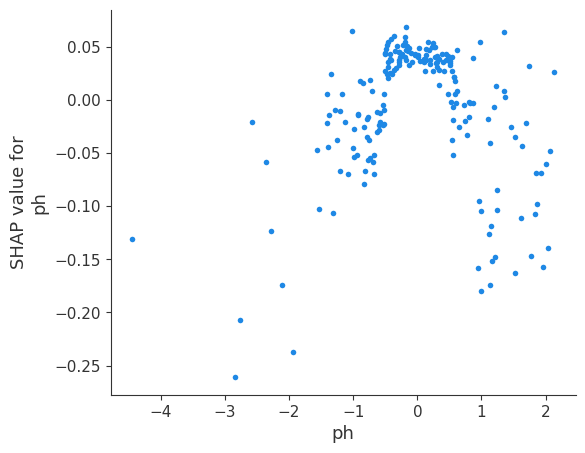

In [ ]:
mean_abs_shap = np.abs(values_to_plot).mean(axis=0)
top_feature_index = np.argmax(mean_abs_shap)
top_feature_name = X_test_imp.columns[top_feature_index]

print(f"\nDependence Plot para la variable: {top_feature_name}")

shap.dependence_plot(
    top_feature_name,
    values_to_plot,
    X_test_imp.iloc[:200],
    interaction_index=None
)